In [35]:
import numpy as np
import pandas as pd
from scipy import stats
import scipy.optimize

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns

import astropy.units as u
import astropy.constants as C

import os
import pickle
import sys
import h5py
import itertools
import importlib
import glob
from tqdm import tqdm
from IPython.core.debugger import set_trace

import peters


cp = sns.color_palette("colorblind", 6)

plt.style.use("/Users/michaelzevin/.MATPLOTLIB_RCPARAMS.sty")

In [50]:
# FIXME: read these from hdf5 file

run = '3channel'
model0 = 'chi01_alpha10'
channels = ['CE', 'GC', 'SMT']
#channels =  ['CE','CHE','GC','NSC','SMT','TRIP']
betas = [0.5, 0.3, 0.2]
#betas = [0.3, 0.1, 0.25, 0.1, 0.2, 0.05]

model_dict =  {'chi00':r'$\chi_{\rm b}=0.0$','chi01':r'$\chi_{\rm b}=0.1$','chi02':r'$\chi_{\rm b}=0.2$','chi05':r'$\chi_{\rm b}=0.5$', \
              'alpha02':r'$\alpha=0.2$','alpha05':r'$\alpha=0.5$','alpha10':r'$\alpha=1.0$','alpha20':r'$\alpha=2.0$','alpha50':r'$\alpha=5.0$'}

In [51]:
basepath = os.path.join('/Users/michaelzevin/research/model_selection/model_selection/trials',run)
n_observations = sorted([int(i) for i in os.listdir(basepath)])

observations = {}
samples =  {}
for N in tqdm(n_observations):
    file_name = 'output_'+model0+'_'+str(N)+'.hdf5'
    observations[N] = pd.read_hdf(os.path.join(basepath,str(N),file_name), key='model_selection/obsdata')
    samples[N] = pd.read_hdf(os.path.join(basepath,str(N),file_name), key='model_selection/samples')



100%|██████████| 8/8 [00:00<00:00, 24.83it/s]


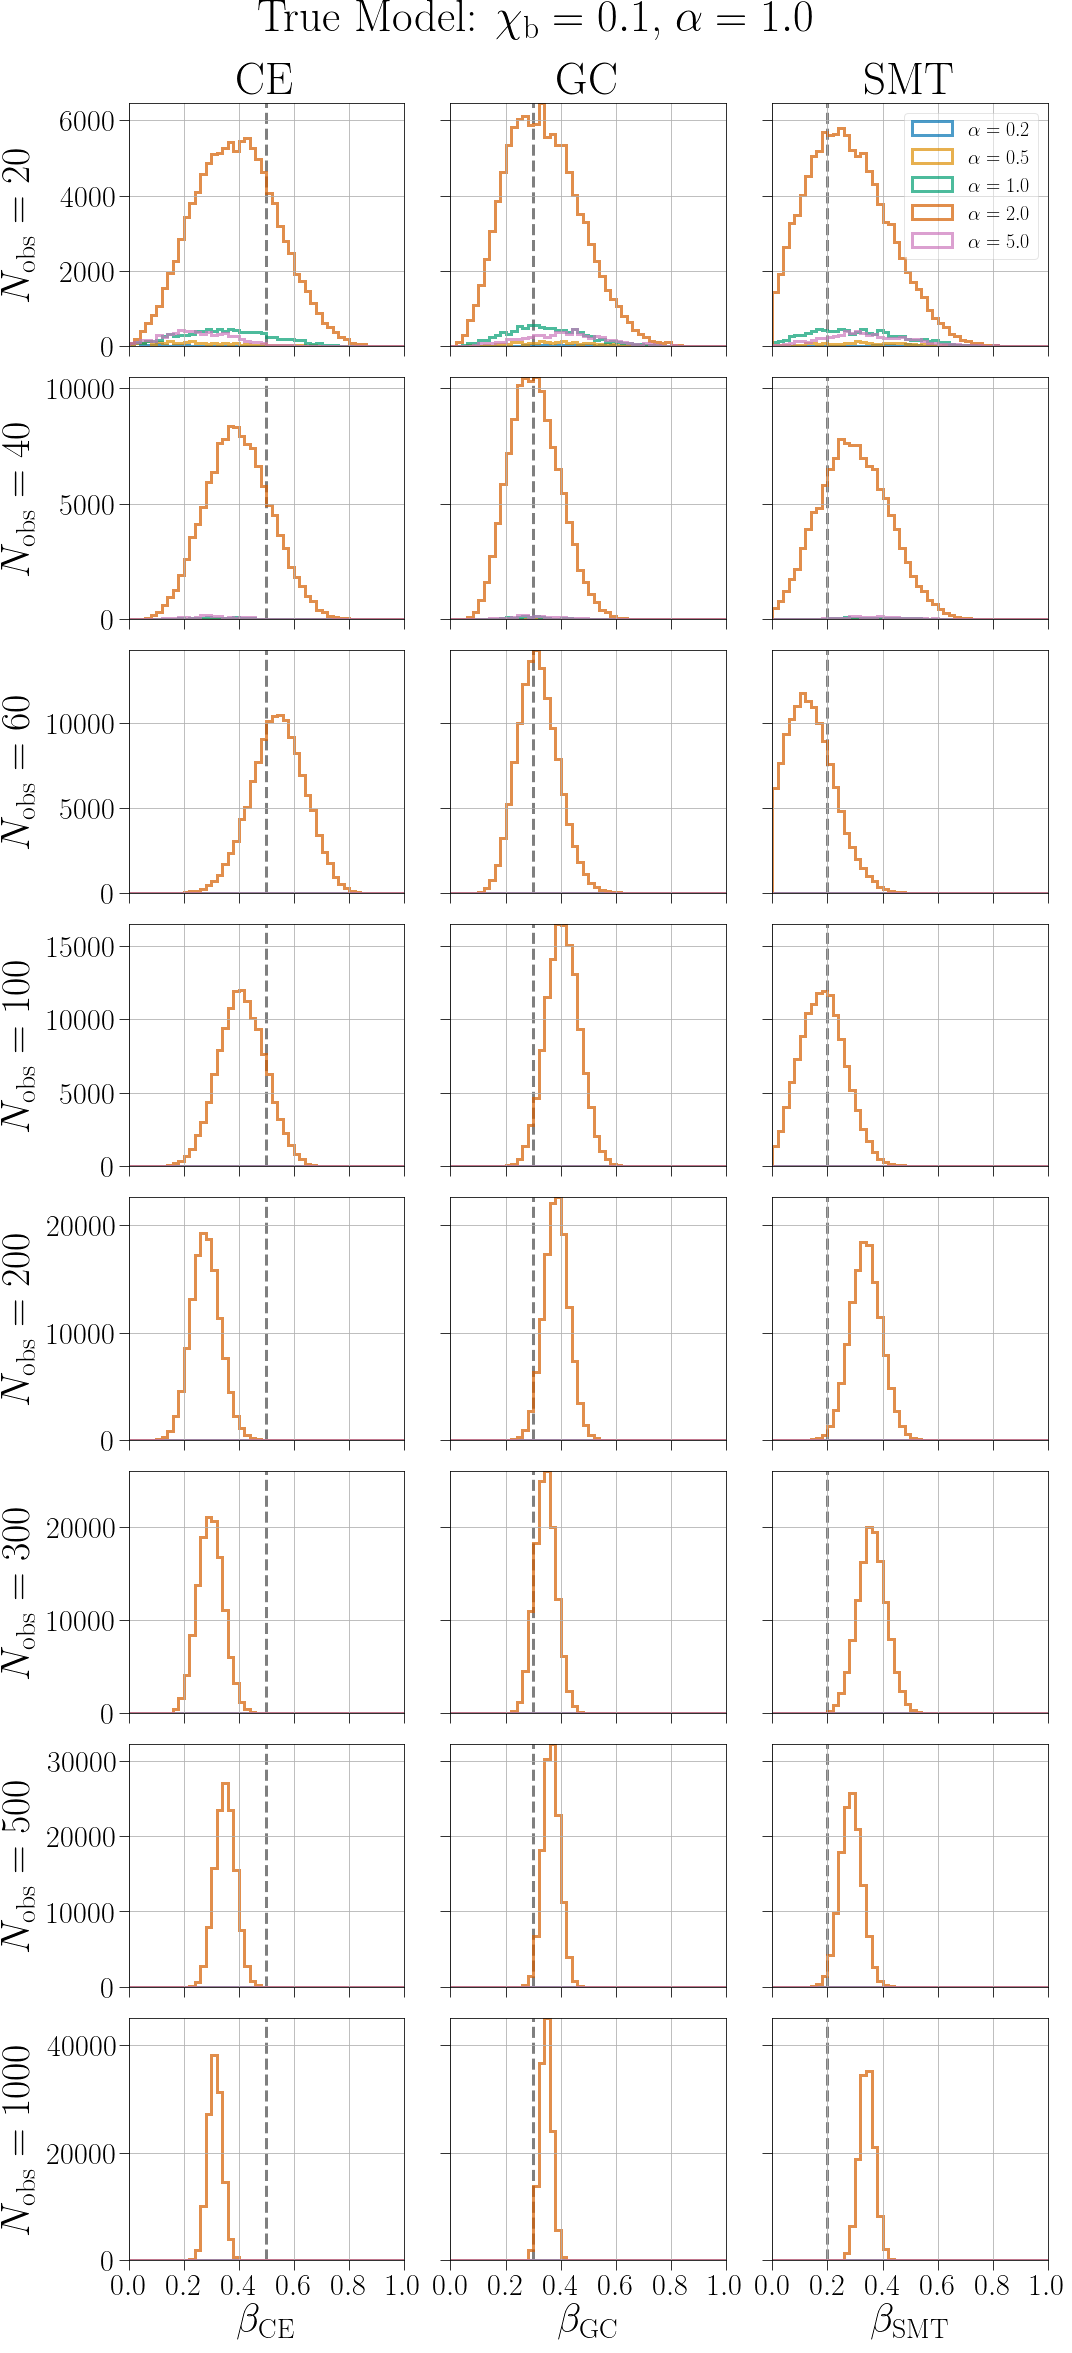

In [53]:
# plot samples as function of Nobs
# each row will be a formation channel, each column will be Nobs

hyperparam = 'p1'
#models =  ['chi00','chi01','chi02','chi05']
models =  ['alpha02','alpha05','alpha10','alpha20','alpha50']

fig, axs = plt.subplots(len(n_observations), len(channels), figsize=(5*len(channels), 4*len(n_observations)))

for nidx, nobs in enumerate(n_observations):
    hmax=0
    samps = samples[nobs]
    subaxs = axs[nidx, :]
    for cidx, channel in enumerate(channels):
        ax = subaxs[cidx]

        # iterate through each model
        for midx, model in enumerate(models):
            beta_posteriors = samps['beta_'+channel].loc[(samps[hyperparam]>=midx) & (samps[hyperparam]<(midx+1))]
            h, bins, _ = ax.hist(beta_posteriors, bins=50, range=(0,1), histtype='step', color=cp[midx], alpha=0.7, lw=3, label=model_dict[model])
            
            # track max height
            hmax = h.max() if h.max()>hmax else hmax
                
        # add observed value
        ax.axvline(betas[cidx], linestyle='--', color='k', alpha=0.5, zorder=-10)
        
        # format axis
        if nidx==0:
            ax.set_title(channel)
        if cidx==0:
            ax.set_ylabel(r'$N_{\rm obs} = %s$' % nobs)
        if nidx==len(n_observations)-1:
            ax.set_xlabel(r'$\beta_{\rm %s}$' % channel, labelpad=10)
        ax.set_xticks(np.arange(0,1.2,0.2))
        if nidx != (len(n_observations)-1):
            ax.set_xticklabels([])
        if cidx != 0:
            ax.set_yticklabels([])
        ax.set_xlim(0,1)
        
    # set ylimit using max hist height
    for cidx, channel in enumerate(channels):
        ax = subaxs[cidx]
        ax.set_ylim(0,hmax)
                
axs[0,-1].legend(prop={'size':20})
model0_name = model0.split('_')
model0_name = [model_dict[x] for x in model0_name]
plt.suptitle('True Model: {}, {}'.format(model0_name[0], model0_name[1]), y=1.02)
fig.align_ylabels(axs[:, :])

plt.tight_layout()
plt.savefig('./trials/figures/{}/samples_{}.png'.format(run,hyperparam))